In [36]:
# HIDDEN
import matplotlib
#matplotlib.use('Agg')
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plt.style.use('fivethirtyeight')

In [37]:
# HIDDEN

def standard_units(x):
    return (x - np.mean(x))/np.std(x)

In [38]:
# HIDDEN

def distance(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, point):
    """The distance between p (an array of numbers) and the numbers in row i of attribute_table."""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(point, np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, point):
    """A copy of the training table with the distance from each row to array p."""
    return training.with_column('Distance', all_distances(training, point))

def closest(training, point, k):
    """A table containing the k closest rows in the training table to array p."""
    with_dists = table_with_distances(training, point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    """1 if the majority of the "Class" column is 1s, and 0 otherwise."""
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    """Classify an example with attributes p using k-nearest neighbor classification with the given training table."""
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

### Nearest Neighbors ###
In this section we'll develop the *nearest neighbor* method of classification. Just focus on the ideas for now and don't worry if some of the code is mysterious. Later in the chapter we'll see how to organize our ideas into code that performs the classification.

### Chronic kidney disease

Let's work through an example.  We're going to work with a data set that was collected to help doctors diagnose chronic kidney disease (CKD).  Each row in the data set represents a single patient who was treated in the past and whose diagnosis is known.  For each patient, we have a bunch of measurements from a blood test.  We'd like to find which measurements are most useful for diagnosing CKD, and develop a way to classify future patients as "has CKD" or "doesn't have CKD" based on their blood test results.

In [39]:
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1
68,80,1.01,3,2,normal,abnormal,present,present,157,90,4.1,130,6.4,5.6,16,11000,2.6,yes,yes,yes,poor,yes,no,1
61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,148,3.9,135,5.2,7.7,24,9200,3.2,yes,yes,yes,poor,yes,yes,1
48,80,1.025,4,0,normal,abnormal,notpresent,notpresent,95,163,7.7,136,3.8,9.8,32,6900,3.4,yes,no,no,good,no,yes,1
69,70,1.01,3,4,normal,abnormal,notpresent,notpresent,264,87,2.7,130,4,12.5,37,9600,4.1,yes,yes,yes,good,yes,no,1
73,70,1.005,0,0,normal,normal,notpresent,notpresent,70,32,0.9,125,4,10,29,18900,3.5,yes,yes,no,good,yes,no,1
73,80,1.02,2,0,abnormal,abnormal,notpresent,notpresent,253,142,4.6,138,5.8,10.5,33,7200,4.3,yes,yes,yes,good,no,no,1
46,60,1.01,1,0,normal,normal,notpresent,notpresent,163,92,3.3,141,4,9.8,28,14600,3.2,yes,yes,no,good,no,no,1


Some of the variables are categorical (words like "abnormal"), and some quantitative. The quantitative variables all have different scales. We're going to want to make comparisons and estimate distances, often by eye, so let's select just a few of the variables and work in standard units. Then we won't have to worry about the scale of each of the different variables.

In [40]:
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'White Blood Cell Count', standard_units(ckd.column('White Blood Cell Count')),
    'Class', ckd.column('Class')
)

In [41]:
ckd

Hemoglobin,Glucose,White Blood Cell Count,Class
-0.865744,-0.221549,-0.569768,1
-1.45745,-0.947597,1.16268,1
-1.00497,3.84123,-1.27558,1
-2.81488,0.396364,0.809777,1
-2.08395,0.643529,0.232293,1
-1.35303,-0.561402,-0.505603,1
-0.413266,2.04928,0.360623,1
-1.28342,-0.947597,3.34429,1
-1.10939,1.87936,-0.409356,1
-1.35303,0.489051,1.96475,1


Let's look at two columns in particular: the hemoglobin level (in the patient's blood), and the blood glucose level (at a random time in the day; without fasting specially for the blood test). 

We'll draw a scatter plot to visualize the relation between the two variables. Blue dots are patients with CKD; gold dots are patients without CKD.  What kind of medical test results seem to indicate CKD?

In [42]:
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)

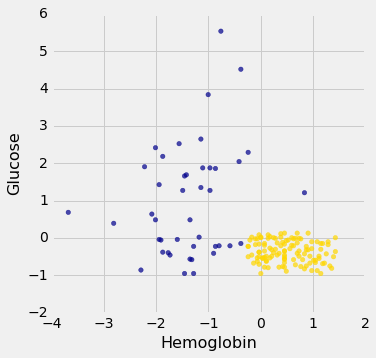

In [43]:
ckd.scatter('Hemoglobin', 'Glucose', colors='Color')

Suppose Alice is a new patient who is not in the data set.  If I tell you Alice's hemoglobin level and blood glucose level, could you predict whether she has CKD?  It sure looks like it!  You can see a very clear pattern here: points in the lower-right tend to represent people who don't have CKD, and the rest tend to be folks with CKD.  To a human, the pattern is obvious.  But how can we program a computer to automatically detect patterns such as this one?

### A Nearest Neighbor Classifier ###

There are lots of kinds of patterns one might look for, and lots of algorithms for classification.  But I'm going to tell you about one that turns out to be surprisingly effective.  It is called *nearest neighbor classification*.  Here's the idea.  If we have Alice's hemoglobin and glucose numbers, we can put her somewhere on this scatterplot; the hemoglobin is her x-coordinate, and the glucose is her y-coordinate.  Now, to predict whether she has CKD or not, we find the nearest point in the scatterplot and check whether it is blue or gold; we predict that Alice should receive the same diagnosis as that patient.

In other words, to classify Alice as CKD or not, we find the patient in the training set who is "nearest" to Alice, and then use that patient's diagnosis as our prediction for Alice.  The intuition is that if two points are near each other in the scatterplot, then the corresponding measurements are pretty similar, so we might expect them to receive the same diagnosis (more likely than not).  We don't know Alice's diagnosis, but we do know the diagnosis of all the patients in the training set, so we find the patient in the training set who is most similar to Alice, and use that patient's diagnosis to predict Alice's diagnosis.

In the graph below, the red dot represents Alice. It is joined with a black line to the point that is nearest to it – its *nearest neighbor* in the training set. The figure is drawn by a function called `show_closest`. It takes an array that represents the $x$ and $y$ coordinates of Alice's point. Vary those to see how the closest point changes! Note especially when the closest point is blue and when it is gold.

In [1]:
# HIDDEN

def show_closest(point):
    """point = array([x,y]) 
    gives the coordinates of a new point
    shown in red"""
    
    HemoGl = ckd.drop('White Blood Cell Count', 'Color')
    t = closest(HemoGl, point, 1)
    x_closest = t.row(0).item(1)
    y_closest = t.row(0).item(2)
    ckd.scatter('Hemoglobin', 'Glucose', colors='Color')
    plt.scatter(point.item(0), point.item(1), color='red', s=30)
    plt.plot(make_array(point.item(0), x_closest), make_array(point.item(1), y_closest), color='k', lw=2);

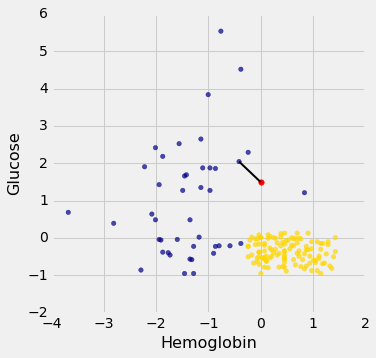

In [45]:
# In this example, Alice's Hemoglobin attribute is 0 and her Glucose is 1.5.
alice = make_array(0, 1.5)
show_closest(alice)

Thus our *nearest neighbor classifier* works like this:
- Find the point in the training set that is nearest to the new point.
- If that nearest point is a "CKD" point, classify the new point as "CKD". If the nearest point is a "not CKD" point, classify the new point as "not CKD".

The scatterplot suggests that this nearest neighbor classifier should be pretty accurate.  Points in the lower-right will tend to receive a "no CKD" diagnosis, as their nearest neighbor will be a gold point.  The rest of the points will tend to receive a "CKD" diagnosis, as their nearest neighbor will be a blue point.  So the nearest neighbor strategy seems to capture our intuition pretty well, for this example.

### Decision boundary ###

Sometimes a helpful way to visualize a classifier is to map out the kinds of attributes where the classifier would predict 'CKD', and the kinds where it would predict 'not CKD'.  We end up with some boundary between the two, where points on one side of the boundary will be classified 'CKD' and points on the other side will be classified 'not CKD'.  This boundary is called the *decision boundary*.  Each different classifier will have a different decision boundary; the decision boundary is just a way to visualize what criteria the classifier is using to classify points.

For example, suppose the coordinates of Alice's point are (0, 1.5). Notice that the nearest neighbor is blue. Now try reducing the height (the $y$-coordinate) of the point. You'll see that at around $y = 0.95$ the nearest neighbor turns from blue to gold.

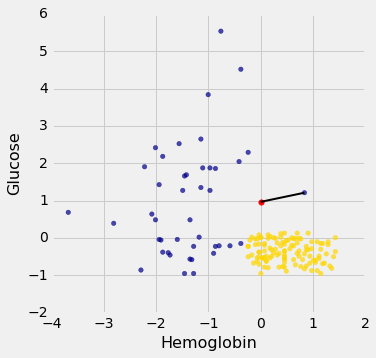

In [46]:
alice = make_array(0, 0.97)
show_closest(alice)

Here are hundreds of new unclassified points, all in red.

In [47]:
# HIDDEN

x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 2.1, 0.1):
    for y in np.arange(-2, 2.1, 0.1):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)
        
test_grid = Table().with_columns(
    'Hemoglobin', x_array,
    'Glucose', y_array
)

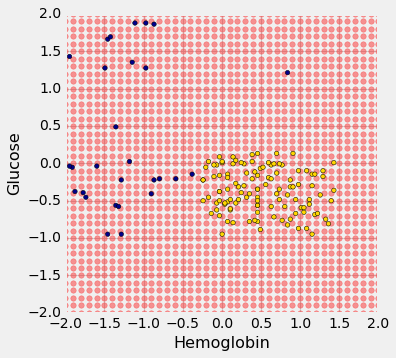

In [48]:
# HIDDEN

test_grid.scatter('Hemoglobin', 'Glucose', color='red', alpha=0.4, s=30)

plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), edgecolor='k')

plt.xlim(-2, 2)
plt.ylim(-2, 2);

Each of the red points has a nearest neighbor in the training set (the same blue and gold points as before). For some red points you can easily tell whether the nearest neighbor is blue or gold. For others, it's a little more tricky to make the decision by eye. Those are the points near the decision boundary.

But the computer can easily determine the nearest neighbor of each point. So let's get it to apply our nearest neighbor classifier to each of the red points: 

For each red point, it must find the closest point in the training set; it must then change the color of the red point to become the color of the nearest neighbor. 

The resulting graph shows which points will get classified as 'CKD' (all the blue ones), and which as 'not CKD' (all the gold ones).

In [49]:
# HIDDEN

def classify_grid(training, test, k):
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c

In [50]:
# HIDDEN

c = classify_grid(ckd.drop('White Blood Cell Count', 'Color'), test_grid, 1)

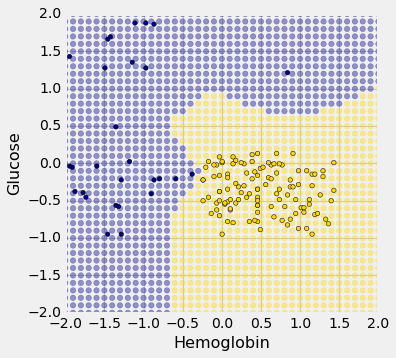

In [51]:
# HIDDEN

test_grid = test_grid.with_column('Class', c).join('Class', color_table)
test_grid.scatter('Hemoglobin', 'Glucose', colors='Color', alpha=0.4, s=30)

plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), edgecolor='k')

plt.xlim(-2, 2)
plt.ylim(-2, 2);

The decision boundary is where the classifier switches from turning the red points blue to turning them gold.

### k-Nearest Neighbors ###

However, the separation between the two classes won't always be quite so clean.  For instance, suppose that instead of hemoglobin levels we were to look at white blood cell count.  Look at what happens:

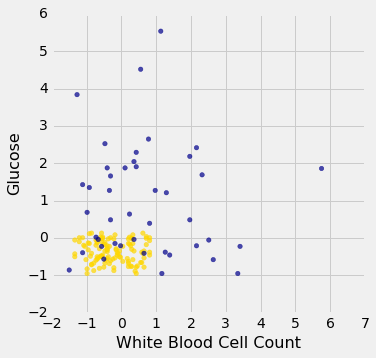

In [52]:
ckd.scatter('White Blood Cell Count', 'Glucose', colors='Color')

As you can see, non-CKD individuals are all clustered in the lower-left.  Most of the patients with CKD are above or to the right of that cluster... but not all.  There are some patients with CKD who are in the lower left of the above figure (as indicated by the handful of blue dots scattered among the gold cluster).  What this means is that you can't tell for certain whether someone has CKD from just these two blood test measurements.

If we are given Alice's glucose level and white blood cell count, can we predict whether she has CKD?  Yes, we can make a prediction, but we shouldn't expect it to be 100% accurate.  Intuitively, it seems like there's a natural strategy for predicting: plot where Alice lands in the scatter plot; if she is in the lower-left, predict that she doesn't have CKD, otherwise predict she has CKD.  

This isn't perfect -- our predictions will sometimes be wrong.  (Take a minute and think it through: for which patients will it make a mistake?)  As the scatterplot above indicates, sometimes people with CKD have glucose and white blood cell levels that look identical to those of someone without CKD, so any classifier is inevitably going to make the wrong prediction for them.

Can we automate this on a computer?  Well, the nearest neighbor classifier would be a reasonable choice here too.  Take a minute and think it through: how will its predictions compare to those from the intuitive strategy above?  When will they differ?

Its predictions will be pretty similar to our intuitive strategy, but occasionally it will make a different prediction.  In particular, if Alice's blood test results happen to put her right near one of the blue dots in the lower-left, the intuitive strategy would predict 'not CKD', whereas the nearest neighbor classifier will predict 'CKD'.

There is a simple generalization of the nearest neighbor classifier that fixes this anomaly.  It is called the *k-nearest neighbor classifier*.  To predict Alice's diagnosis, rather than looking at just the one neighbor closest to her, we can look at the 3 points that are closest to her, and use the diagnosis for each of those 3 points to predict Alice's diagnosis.  In particular, we'll use the majority value among those 3 diagnoses as our prediction for Alice's diagnosis.  Of course, there's nothing special about the number 3: we could use 4, or 5, or more.  (It's often convenient to pick an odd number, so that we don't have to deal with ties.)  In general, we pick a number $k$, and our predicted diagnosis for Alice is based on the $k$ patients in the training set who are closest to Alice.  Intuitively, these are the $k$ patients whose blood test results were most similar to Alice, so it seems reasonable to use their diagnoses to predict Alice's diagnosis.

The $k$-nearest neighbor classifier will now behave just like our intuitive strategy above.